In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
data = pd.read_csv("train.csv")
data.head(3)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


In [3]:
data.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [4]:
data.shape

(1804874, 45)

In [5]:
def partition(x):
    if x>=0.5:
        return 1
    else:
        return 0
    
actualscore=data["target"]
PositiveNegative = actualscore.map(partition)
data["target"] = PositiveNegative
print("Number of data points in our data",data.shape)
data.head(3)


Number of data points in our data (1804874, 45)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


In [6]:
data["target"].value_counts()

0    1660540
1     144334
Name: target, dtype: int64

In [7]:
print(data["comment_text"].values[100])
print("="*50)
print(data["comment_text"].values[1000])
print("="*50)
print(data["comment_text"].values[2000])

Loving this collection. Cant wait till Season 2 is released. Should be any day now according to http://yeezy-season2.com/
I feel as if Oregon could make itself known to the world for other things, like becoming a leader on carbon pricing or other climate policies. But maybe that's hopelessly idealistic.
I equally love men. leafy i love you. hugs and kisses.


In [8]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_comment = []
# tqdm is for printing the status bar
for sentance in tqdm(data['comment_text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_comment.append(sentance.strip())

  4%|▍         | 70128/1804874 [00:18<06:57, 4158.81it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 13%|█▎        | 234723/1804874 [00:58<06:16, 4175.50it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b". . . that includes his 'female chest pushing' virtuous elbows.\n\nIt would do well, for the guy who got the job because of his father's name, to remain quiet.\n\n/.."" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 14%|█▍        | 256004/1804874 [01:03<06:14, 4131.84it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.....'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful 

 43%|████▎     | 779789/1804874 [03:09<04:08, 4131.91it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 43%|████▎     | 780203/1804874 [03:09<04:10, 4088.85it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 44%|████▍     | 791134/1804874 [03:12<03:58, 4253.74it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 44%|████▍     | 799262/1804874 [03:14<03:55, 4269.15it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarnin

 51%|█████     | 921153/1804874 [03:43<03:36, 4081.97it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'The Sale of Hydro One is completely disgusting...\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 52%|█████▏    | 936149/1804874 [03:47<03:29, 4155.06it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 52%|█████▏    | 936985/1804874 [03:47<03:29, 4136.70it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Nicely said... \n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.

 59%|█████▊    | 1056818/1804874 [04:16<02:59, 4174.83it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Systematic take over of Canada... Priceless!\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'"Why I won\'t leave London, ever..."\n\nInteresting.\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 59%|█████▊    | 1057643/1804874 [04:16<03:04, 4052.94it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b"The level of 'Censorship' with this story is utterly disgusting, Globe and Mail.\n\n/.."" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % mar

C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Well Said..\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 64%|██████▍   | 1152525/1804874 [04:39<02:37, 4152.41it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 64%|██████▍   | 1155111/1804874 [04:40<02:31, 4302.38it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'2003 - 2004 . . . Liberals under Prime Minister Paul Martin.\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 64%|██████▍   | 1155542/1804874 [04:40<02:39, 4064.96it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4

 67%|██████▋   | 1205176/1804874 [04:52<02:20, 4267.80it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Exciting Suff.. !!\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b"I'm with you...\n\n/.."" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'How interesting...\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Ditto...\n\n/..'" looks like a filename, not markup. You should probably open this file and pass t

 79%|███████▉  | 1432608/1804874 [05:50<02:02, 3035.84it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'The Americans certainly have their problems right now...\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 80%|████████  | 1450194/1804874 [05:55<01:25, 4158.43it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Nicely Said...\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b". . . likely for having to listen to this woman's bigoted racist trash-talk..\n\n/.."" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\MERCER\Anaconda

 90%|████████▉ | 1619226/1804874 [06:35<00:44, 4184.97it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Well Said, OrsonW.. !\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 92%|█████████▏| 1666224/1804874 [06:46<00:32, 4246.82it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Excellent Comment... Well Said, Teddy.\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 92%|█████████▏| 1667071/1804874 [06:47<00:33, 4169.22it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b"Trudeau's bolo punch with his aggressive taxing & spending on those who can not defend themselves... ergo, Trudeau's dumb management of our Canada's Finances.\n \nMr. Divisive -- That's Who.\n\n/.."" looks lik

In [11]:
preprocessed_comment[100]

'loving collection cant wait till season released day according'

In [12]:
data.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,7.996902e-02,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,2.445187e+06,2.712453e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.769854e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [13]:
data["preprocessed_text"] = preprocessed_comment
data.head(3)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
0,59848,0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read really great ...
1,59849,0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxiety inducin...
2,59852,0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudos taking impressive


In [14]:
data.shape

(1804874, 46)

In [16]:

final_data = data.sample(n=500000)

In [18]:

final_data["target"].value_counts()

0    459786
1     40214
Name: target, dtype: int64

In [19]:
# Train test split

from sklearn.model_selection import train_test_split

y = final_data['target'].values
#final_data.drop(['target'], axis=1, inplace=True)      # drop project is approved columns  
x = final_data

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,stratify = y)


print(x_train.shape)

print(x_test.shape)



(400000, 46)
(100000, 46)


In [20]:
x_train.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
787703,5084985,0,Among the most recent videos posted to youtube...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,1,0,0,4,0.0,0,4,among recent videos posted youtube group fbi e...
701422,4980923,0,"""It was neither a rebuke nor an endorsement.""\...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,4,neither rebuke nor endorsement roflmao link ac...


# Check performance of this feature

In [21]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Tfidf

In [22]:
# On Clean Essay
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer8 = TfidfVectorizer(min_df=10,ngram_range = (1,4),max_features = 100000)
preprocessed_text_xtr_tfidf = vectorizer8.fit_transform(x_train['preprocessed_text'])
preprocessed_text_xtr_tfidf = normalize(preprocessed_text_xtr_tfidf)
print("Shape of matrix after one hot encodig ",preprocessed_text_xtr_tfidf.shape)

preprocessed_text_xtest_tfidf = vectorizer8.transform(x_test['preprocessed_text'])
preprocessed_text_xtest_tfidf = normalize(preprocessed_text_xtest_tfidf)
print("Shape of matrix after one hot encodig ",preprocessed_text_xtest_tfidf.shape)

Shape of matrix after one hot encodig  (400000, 100000)
Shape of matrix after one hot encodig  (100000, 100000)


# Logistic Regression


In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

parameters2={'alpha': [10**x for x in range(-10,1)] ,
             
             'penalty' : ['l1','l2']}

clf_sgd2 = SGDClassifier(loss = 'log',random_state=11,class_weight='balanced')

clf2=GridSearchCV(clf_sgd2 ,param_grid = parameters2, scoring="roc_auc", cv=10, verbose=12, n_jobs=8)
clf2.fit(preprocessed_text_xtr_tfidf,y_train)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   21.4s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   21.5s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:   21.7s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:   21.7s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:   21.8s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:   23.5s
[Parallel(

[Parallel(n_jobs=8)]: Done 135 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 137 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 138 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 139 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 140 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 141 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 142 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 143 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 144 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 145 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 147 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 148 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 149 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 150 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Do

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=11, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'alpha': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=12)

In [24]:
a2=clf2.best_params_['alpha']
p2 = clf2.best_params_['penalty']

print(clf2.best_score_)
print(a2)
print(p2)


0.9337614905819163
1e-05
l2


In [25]:
model_new2 = SGDClassifier(alpha=a2,penalty = p2,loss = 'log',random_state=11,class_weight='balanced')
model_new2.fit(preprocessed_text_xtr_tfidf,y_train)

SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=11, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

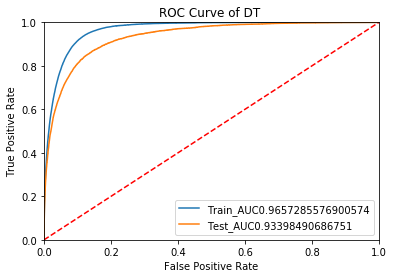

In [26]:
from  sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


score_roc_train = model_new2.predict_proba(preprocessed_text_xtr_tfidf)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, score_roc_train[:,1])
roc_auc_train = auc(fpr_train, tpr_train)

score_roc_test = model_new2.predict_proba(preprocessed_text_xtest_tfidf)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, score_roc_test[:,1])
roc_auc_test = auc(fpr_test, tpr_test)


plt.plot(fpr_train, tpr_train, label = "Train_AUC"+str(auc(fpr_train, tpr_train)))
plt.plot(fpr_test, tpr_test, label = "Test_AUC"+str(auc(fpr_test, tpr_test)))
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of DT ')
plt.show()


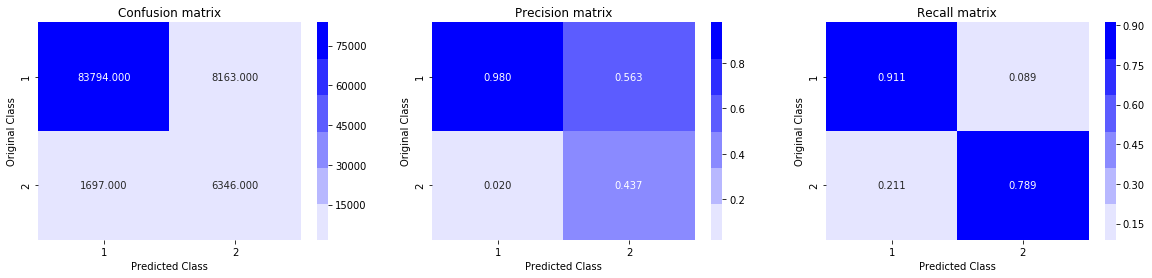

In [27]:
y_test_pred_tfidf = model_new2.predict(preprocessed_text_xtest_tfidf)

plot_confusion_matrix(y_test, y_test_pred_tfidf)

# Linear SVM

In [28]:
import numpy as np
import math

# custom function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# test
scores = np.array([ -0.54761371,  17.04850603,   4.86054302])
print (sigmoid_v(scores))

[0.36641822 0.99999996 0.99231327]


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier


clf_param_grid = {
    'alpha' : [10**-x for x in range(-6,5)],
    'penalty' : ['l1','l2']
}
SGD_svm = SGDClassifier(class_weight='balanced',eta0 = 0.05)

estimator_svm = GridSearchCV(SGD_svm, param_grid=clf_param_grid ,cv=10, verbose=12, scoring="roc_auc",n_jobs=-1)
estimator_svm.fit(preprocessed_text_xtr_tfidf,y_train)

print(estimator_svm.best_params_)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  2.5min
[Paralle

{'alpha': 0.0001, 'penalty': 'l2'}


In [34]:
b2=estimator_svm.best_params_["alpha"]
p2=estimator_svm.best_params_["penalty"]
print(estimator_svm.best_score_)

0.9253663212938843


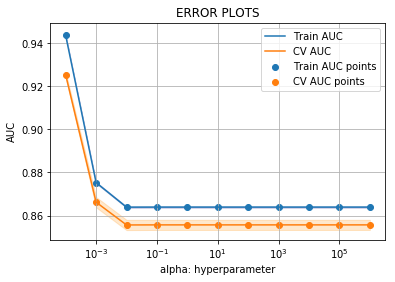

In [35]:
train_auc2= estimator_svm.cv_results_['mean_train_score'][estimator_svm.cv_results_['param_penalty']==p2]
train_auc_std2= estimator_svm.cv_results_['std_train_score'][estimator_svm.cv_results_['param_penalty']==p2]
cv_auc2 = estimator_svm.cv_results_['mean_test_score'][estimator_svm.cv_results_['param_penalty']==p2]
cv_auc_std2= estimator_svm.cv_results_['std_test_score'][estimator_svm.cv_results_['param_penalty']==p2]

ax=plt.subplot()
plt.plot(clf_param_grid['alpha'], train_auc2, label='Train AUC')

# this code is copied from here: https://stackoverflow.com/a/48803362/4084039
plt.gca().fill_between(clf_param_grid['alpha'],train_auc2 - train_auc_std2,train_auc2 + train_auc_std2,alpha=0.2,color='darkblue')
# create a shaded area between [mean - std, mean + std]

plt.plot(clf_param_grid['alpha'], cv_auc2, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803362/4084039
plt.gca().fill_between(clf_param_grid['alpha'],cv_auc2 - cv_auc_std2,cv_auc2 + cv_auc_std2,alpha=0.2,color='darkorange')

plt.scatter(clf_param_grid['alpha'], train_auc2, label='Train AUC points')
plt.scatter(clf_param_grid['alpha'], cv_auc2, label='CV AUC points')

plt.xscale('log')
plt.axis('tight')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [37]:
model_new_svm=SGDClassifier( penalty=p2, alpha= b2,class_weight='balanced')
model_new_svm.fit(preprocessed_text_xtr_tfidf,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

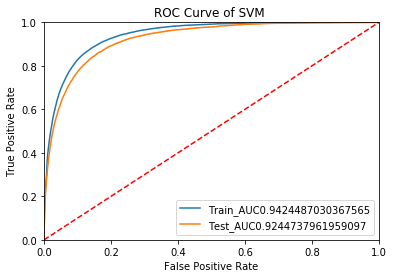

In [38]:
score_roc_train = model_new_svm.decision_function(preprocessed_text_xtr_tfidf)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, sigmoid_v(score_roc_train))
roc_auc_train = auc(fpr_train, tpr_train)

score_roc_test = model_new_svm.decision_function(preprocessed_text_xtest_tfidf)
fpr_test, tpr_test, threshold_test = roc_curve(y_test,sigmoid_v (score_roc_test))
roc_auc_test = auc(fpr_test, tpr_test)


plt.plot(fpr_train, tpr_train, label = "Train_AUC"+str(auc(fpr_train, tpr_train)))
plt.plot(fpr_test, tpr_test, label = "Test_AUC"+str(auc(fpr_test, tpr_test)))
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of SVM ')
plt.show()

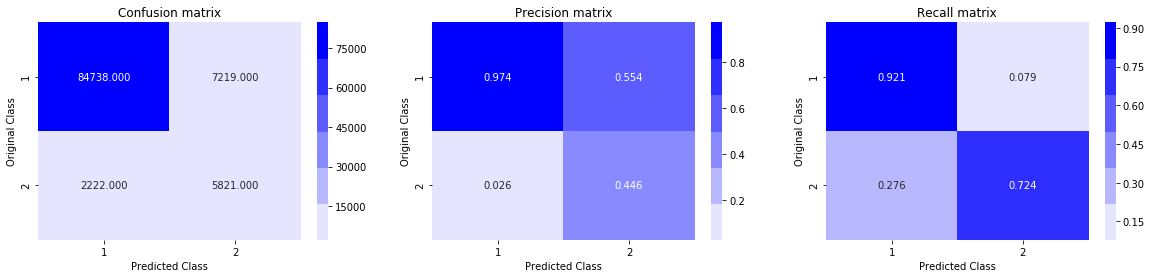

In [39]:
y_test_pred_svm = model_new_svm.predict(preprocessed_text_xtest_tfidf)

plot_confusion_matrix(y_test, y_test_pred_svm)

# Naive Base


In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

params={'alpha' : [10**i for i in range(-6,5)]}

clf_tfidf_NB = MultinomialNB(alpha = 'alpha')

clf_NB=GridSearchCV(clf_tfidf_NB ,param_grid = params, scoring="roc_auc", cv=10, verbose=12, n_jobs=-1)
clf_NB.fit(preprocessed_text_xtr_tfidf,y_train)
clf_NB.best_params_,clf_NB.best_estimator_,clf_NB.best_score_

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

({'alpha': 0.1},
 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True),
 0.848894691597666)

In [41]:
a2 = clf_NB.best_params_["alpha"]

print(a2)


0.1


In [42]:
model_new_NB = MultinomialNB(alpha = a2 )
model_new_NB.fit(preprocessed_text_xtr_tfidf,y_train)


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

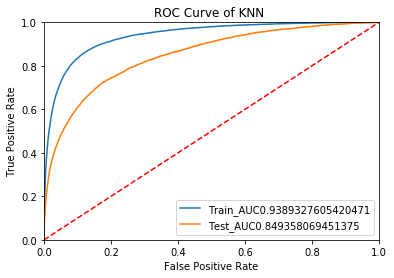

In [43]:
from  sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


score_roc_train = model_new_NB.predict_proba(preprocessed_text_xtr_tfidf)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, score_roc_train[:,1])
roc_auc_train = auc(fpr_train, tpr_train)

score_roc_test = model_new_NB.predict_proba(preprocessed_text_xtest_tfidf)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, score_roc_test[:,1])
roc_auc_test = auc(fpr_test, tpr_test)


plt.plot(fpr_train, tpr_train, label = "Train_AUC"+str(auc(fpr_train, tpr_train)))
plt.plot(fpr_test, tpr_test, label = "Test_AUC"+str(auc(fpr_test, tpr_test)))
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of KNN ')
plt.show()


# Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



clf_tfidf_RF = RandomForestClassifier(n_estimators= 2000,max_depth = 10,class_weight = "balanced_subsample")

clf_tfidf_RF.fit(preprocessed_text_xtr_tfidf,y_train)


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

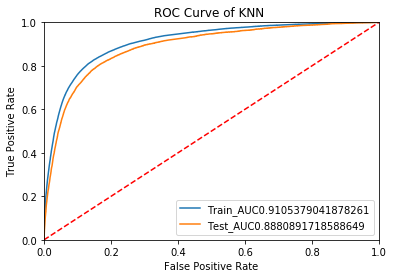

In [48]:
from  sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


score_roc_train = clf_tfidf_RF.predict_proba(preprocessed_text_xtr_tfidf)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, score_roc_train[:,1])
roc_auc_train = auc(fpr_train, tpr_train)

score_roc_test = clf_tfidf_RF.predict_proba(preprocessed_text_xtest_tfidf)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, score_roc_test[:,1])
roc_auc_test = auc(fpr_test, tpr_test)


plt.plot(fpr_train, tpr_train, label = "Train_AUC"+str(auc(fpr_train, tpr_train)))
plt.plot(fpr_test, tpr_test, label = "Test_AUC"+str(auc(fpr_test, tpr_test)))
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of KNN ')
plt.show()


# Predict final submissions

In [29]:
test_data = pd.read_csv("test.csv")
test_data.head(3)

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...


In [30]:
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_comment_test = []
# tqdm is for printing the status bar
for sentance in tqdm(test_data['comment_text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_comment_test.append(sentance.strip())

 10%|█         | 10091/97320 [00:02<00:21, 4034.81it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b"I think I'm cooler than the blonde ones. Not that I don't love them, you know, family/.."" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 14%|█▍        | 13592/97320 [00:03<00:24, 3373.91it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 20%|█▉        | 19109/97320 [00:04<00:19, 3941.68it/s]C:\Users\MERCER\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Who really cares? ..\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 30%|███       | 29439/97320 

In [31]:
test_data["preprocessed_text_test_pred"] = preprocessed_comment_test
test_data.head(3)

,id,comment_text,preprocessed_text_test_pred
0,7000000,Jeff Sessions is another one of Trump's Orwell...,jeff sessions another one trump orwellian choi...
1,7000001,I actually inspected the infrastructure on Gra...,actually inspected infrastructure grand chief ...
2,7000002,No it won't . That's just wishful thinking on ...,no not wishful thinking democrats fault th tim...


In [33]:
test_data.shape

(97320, 3)

In [34]:
# On Clean Essay
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer


preprocessed_text_xtest_pred = vectorizer8.transform(test_data['preprocessed_text_test_pred'])
preprocessed_text_xtest_pred = normalize(preprocessed_text_xtest_pred)
print("Shape of matrix after one hot encodig ",preprocessed_text_xtest_pred.shape)


Shape of matrix after one hot encodig  (97320, 100000)


In [47]:
my_preds = model_new2.predict_proba(preprocessed_text_xtest_pred)

In [50]:
print(my_preds.shape)
my_preds


(97320, 2)


array([[0.70656124, 0.29343876],
       [0.87401351, 0.12598649],
       [0.81944327, 0.18055673],
       ...,
       [0.90309973, 0.09690027],
       [0.19976408, 0.80023592],
       [0.7070679 , 0.2929321 ]])

In [53]:
my_preds[:,0]

array([0.70656124, 0.87401351, 0.81944327, ..., 0.90309973, 0.19976408,
       0.7070679 ])

In [55]:
predids=test_data['id']
y_id=predids.values.tolist()

preddf=pd.DataFrame({'id':y_id,
                     'target':my_preds[:,0]})

#look at predictions
preddf.head(3)




,id,target
0,7000000,0.706561
1,7000001,0.874014
2,7000002,0.819443


In [57]:
# SAVE DF
preddf.to_csv('final_submission_LR_eshan1.csv',index=False)



In [58]:
preddf.shape

(97320, 2)